In [1]:
# [Cell 1] 환경 설정 및 라이브러리 임포트
from google.colab import drive
drive.mount('/content/drive')

import os
import cv2
import numpy as np
import cupy as cp  # GPU 가속을 위한 라이브러리 (Numpy와 문법 유사)
import time

# GPU 확인
try:
    print(f"Detected GPU: {cp.cuda.runtime.getDeviceCount()}")
except:
    print("GPU를 찾을 수 없습니다. 런타임 유형을 GPU로 변경해주세요.")

# 시드 고정
np.random.seed(42)
cp.random.seed(42)

print("라이브러리 로드 완료")

Mounted at /content/drive
Detected GPU: 1
라이브러리 로드 완료


In [8]:
# [Cell 2] 수정됨: Assertion 제거 및 유연한 im2col 구현

def get_im2col_indices(x_shape, field_height, field_width, padding=1, stride=1):
    N, C, H, W = x_shape

    # 수정: assert 문 제거 (나누어 떨어지지 않아도 버림 처리하여 진행)
    out_height = (H + 2 * padding - field_height) // stride + 1
    out_width = (W + 2 * padding - field_width) // stride + 1

    i0 = np.repeat(np.arange(field_height), field_width)
    i0 = np.tile(i0, C)
    i1 = stride * np.repeat(np.arange(out_height), out_width)
    j0 = np.tile(np.arange(field_width), field_height * C)
    j1 = stride * np.tile(np.arange(out_width), out_height)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)
    k = np.repeat(np.arange(C), field_height * field_width).reshape(-1, 1)
    return (k, i, j)

def im2col_indices(x, field_height, field_width, padding=1, stride=1):
    p = padding
    x_padded = cp.pad(x, ((0, 0), (0, 0), (p, p), (p, p)), mode='constant')
    k, i, j = get_im2col_indices(x.shape, field_height, field_width, padding, stride)

    k = cp.array(k)
    i = cp.array(i)
    j = cp.array(j)

    cols = x_padded[:, k, i, j]
    C = x.shape[1]
    cols = cols.transpose(1, 2, 0).reshape(field_height * field_width * C, -1)
    return cols

def col2im_indices(cols, x_shape, field_height=3, field_width=3, padding=1, stride=1):
    N, C, H, W = x_shape
    H_padded, W_padded = H + 2 * padding, W + 2 * padding
    x_padded = cp.zeros((N, C, H_padded, W_padded), dtype=cols.dtype)
    k, i, j = get_im2col_indices(x_shape, field_height, field_width, padding, stride)

    k = cp.array(k)
    i = cp.array(i)
    j = cp.array(j)

    cols_reshaped = cols.reshape(C * field_height * field_width, -1, N)
    cols_reshaped = cols_reshaped.transpose(2, 0, 1)
    cp.add.at(x_padded, (slice(None), k, i, j), cols_reshaped)

    if padding == 0:
        return x_padded
    return x_padded[:, :, padding:-padding, padding:-padding]

In [9]:
# [Cell 3] 딥러닝 레이어 직접 구현

class Layer:
    def forward(self, x): pass
    def backward(self, dout): pass

class ReLU(Layer):
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out
    def backward(self, dout):
        dout[self.mask] = 0
        return dout

class FullyConnected(Layer):
    def __init__(self, input_size, output_size):
        # He Initialization
        self.W = cp.random.randn(input_size, output_size) * cp.sqrt(2.0 / input_size)
        self.b = cp.zeros(output_size)
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x_shape = x.shape
        self.x = x.reshape(x.shape[0], -1)
        return cp.dot(self.x, self.W) + self.b

    def backward(self, dout):
        self.dW = cp.dot(self.x.T, dout)
        self.db = cp.sum(dout, axis=0)
        dx = cp.dot(dout, self.W.T)
        return dx.reshape(self.x_shape)

class Conv2D(Layer):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        self.in_c = in_channels
        self.out_c = out_channels
        self.k_h = kernel_size
        self.k_w = kernel_size
        self.stride = stride
        self.pad = padding

        # He Initialization
        scale = cp.sqrt(2.0 / (in_channels * kernel_size * kernel_size))
        self.W = cp.random.randn(out_channels, in_channels, kernel_size, kernel_size) * scale
        self.b = cp.zeros(out_channels)

    def forward(self, x):
        self.x = x
        n, c, h, w = x.shape
        out_h = (h + 2*self.pad - self.k_h) // self.stride + 1
        out_w = (w + 2*self.pad - self.k_w) // self.stride + 1

        self.x_cols = im2col_indices(x, self.k_h, self.k_w, self.pad, self.stride)
        res = self.W.reshape(self.out_c, -1).dot(self.x_cols) + self.b.reshape(-1, 1)

        out = res.reshape(self.out_c, out_h, out_w, n)
        return out.transpose(3, 0, 1, 2)

    def backward(self, dout):
        n, c, h, w = self.x.shape
        dout_reshaped = dout.transpose(1, 2, 3, 0).reshape(self.out_c, -1)

        self.db = cp.sum(dout_reshaped, axis=1)
        self.dW = dout_reshaped.dot(self.x_cols.T).reshape(self.W.shape)

        d_cols = self.W.reshape(self.out_c, -1).T.dot(dout_reshaped)
        dx = col2im_indices(d_cols, self.x.shape, self.k_h, self.k_w, self.pad, self.stride)
        return dx

class BatchNorm(Layer):
    def __init__(self, num_features, momentum=0.9):
        self.gamma = cp.ones(num_features)
        self.beta = cp.zeros(num_features)
        self.momentum = momentum
        self.running_mean = cp.zeros(num_features)
        self.running_var = cp.zeros(num_features)
        self.epsilon = 1e-5
        self.mode = 'train' # or 'test'

    def forward(self, x):
        N, C, H, W = x.shape
        x_flat = x.transpose(0, 2, 3, 1).reshape(-1, C) # (N*H*W, C)

        if self.mode == 'train':
            mu = cp.mean(x_flat, axis=0)
            xc = x_flat - mu
            var = cp.mean(xc**2, axis=0)
            std = cp.sqrt(var + self.epsilon)
            xn = xc / std

            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * var

            self.cache = (x_flat, xc, xn, std, var, mu)
        else:
            xc = x_flat - self.running_mean
            xn = xc / cp.sqrt(self.running_var + self.epsilon)

        out = self.gamma * xn + self.beta
        return out.reshape(N, H, W, C).transpose(0, 3, 1, 2)

    def backward(self, dout):
        N, C, H, W = dout.shape
        dout_flat = dout.transpose(0, 2, 3, 1).reshape(-1, C)
        x_flat, xc, xn, std, var, mu = self.cache

        N_flat = x_flat.shape[0]

        dbeta = cp.sum(dout_flat, axis=0)
        dgamma = cp.sum(xn * dout_flat, axis=0)

        dxn = self.gamma * dout_flat
        dxc = dxn / std
        dvar = cp.sum(dxn * xc * -0.5 * std**(-3), axis=0)
        dmu = cp.sum(dxc * -1, axis=0) + dvar * cp.mean(-2.0 * xc, axis=0)

        dx = dxc + (dmu / N_flat) + (dvar * 2.0 * xc / N_flat)

        self.dgamma = dgamma
        self.dbeta = dbeta

        return dx.reshape(N, H, W, C).transpose(0, 3, 1, 2)

class GlobalAveragePool(Layer):
    def forward(self, x):
        self.x_shape = x.shape
        return cp.mean(x, axis=(2, 3))

    def backward(self, dout):
        N, C, H, W = self.x_shape
        return (dout[:, :, None, None] / (H * W)) * cp.ones(self.x_shape)

class MaxPool2D(Layer):
    def __init__(self, pool_size=2, stride=2):
        self.pool = pool_size
        self.stride = stride

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = (H - self.pool) // self.stride + 1
        out_w = (W - self.pool) // self.stride + 1

        col = im2col_indices(x, self.pool, self.pool, padding=0, stride=self.stride)
        col = col.reshape(-1, self.pool*self.pool)

        arg_max = cp.argmax(col, axis=1)
        out = cp.max(col, axis=1)
        out = out.reshape(out_h, out_w, N, C).transpose(2, 3, 0, 1)

        self.x_shape = x.shape
        self.arg_max = arg_max
        return out

    def backward(self, dout):
        # 간략한 구현 (속도를 위해 인덱스 매핑이 복잡하므로 여기서는 근사 혹은 생략할 수 없으니 정석대로)
        # 단, 구현 복잡도를 줄이기 위해 MaxPool Backward는 매우 느릴 수 있습니다.
        # POC Dataset이 크지 않다면 괜찮습니다.
        N, C, H, W = self.x_shape
        pool = self.pool
        dout_reshaped = dout.transpose(2, 3, 0, 1).flatten()

        dmax = cp.zeros((dout.size, pool * pool))
        dmax[cp.arange(self.arg_max.size), self.arg_max.flatten()] = dout_reshaped
        dmax = dmax.reshape(dout.shape[2] * dout.shape[3] * N * C, -1)

        dx = col2im_indices(dmax.T, self.x_shape, pool, pool, padding=0, stride=self.stride)
        return dx

In [10]:
# [Cell 4] ResNet-50 아키텍처 조립

class Bottleneck:
    def __init__(self, in_channels, mid_channels, out_channels, stride=1, downsample=None):
        self.conv1 = Conv2D(in_channels, mid_channels, 1, stride=1)
        self.bn1 = BatchNorm(mid_channels)
        self.relu1 = ReLU()

        self.conv2 = Conv2D(mid_channels, mid_channels, 3, stride=stride, padding=1)
        self.bn2 = BatchNorm(mid_channels)
        self.relu2 = ReLU()

        self.conv3 = Conv2D(mid_channels, out_channels, 1, stride=1)
        self.bn3 = BatchNorm(out_channels)

        self.relu3 = ReLU()
        self.downsample = downsample # Shortcut connection (conv + bn)

    def forward(self, x):
        identity = x

        out = self.conv1.forward(x)
        out = self.bn1.forward(out)
        out = self.relu1.forward(out)

        out = self.conv2.forward(out)
        out = self.bn2.forward(out)
        out = self.relu2.forward(out)

        out = self.conv3.forward(out)
        out = self.bn3.forward(out)

        if self.downsample is not None:
            identity = self.downsample[0].forward(x) # conv
            identity = self.downsample[1].forward(identity) # bn

        out += identity
        out = self.relu3.forward(out)
        return out

    def backward(self, dout):
        dout = self.relu3.backward(dout)

        # Branch 1 (Main)
        d_main = dout.copy()
        d_main = self.bn3.backward(d_main)
        d_main = self.conv3.backward(d_main)

        d_main = self.relu2.backward(d_main)
        d_main = self.bn2.backward(d_main)
        d_main = self.conv2.backward(d_main)

        d_main = self.relu1.backward(d_main)
        d_main = self.bn1.backward(d_main)
        d_main = self.conv1.backward(d_main)

        # Branch 2 (Shortcut)
        d_shortcut = dout.copy()
        if self.downsample is not None:
            d_shortcut = self.downsample[1].backward(d_shortcut)
            d_shortcut = self.downsample[0].backward(d_shortcut)

        return d_main + d_shortcut

    def get_params(self):
        params = [self.conv1, self.bn1, self.conv2, self.bn2, self.conv3, self.bn3]
        if self.downsample:
            params.extend(self.downsample)
        return params

class ResNet50:
    def __init__(self, num_classes=4):
        self.in_channels = 64

        # Initial Stage
        self.conv1 = Conv2D(3, 64, 7, stride=2, padding=3)
        self.bn1 = BatchNorm(64)
        self.relu = ReLU()
        self.maxpool = MaxPool2D(3, stride=2)

        # Stages
        self.layer1 = self._make_layer(64, 256, 3, stride=1)
        self.layer2 = self._make_layer(128, 512, 4, stride=2)
        self.layer3 = self._make_layer(256, 1024, 6, stride=2)
        self.layer4 = self._make_layer(512, 2048, 3, stride=2)

        self.avgpool = GlobalAveragePool()
        self.fc = FullyConnected(2048, num_classes)

    def _make_layer(self, mid_channels, out_channels, blocks, stride=1):
        layers = []
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = [
                Conv2D(self.in_channels, out_channels, 1, stride=stride),
                BatchNorm(out_channels)
            ]

        layers.append(Bottleneck(self.in_channels, mid_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(Bottleneck(self.in_channels, mid_channels, out_channels))

        return layers

    def forward(self, x):
        x = self.conv1.forward(x)
        x = self.bn1.forward(x)
        x = self.relu.forward(x)
        x = self.maxpool.forward(x)

        for block in self.layer1: x = block.forward(x)
        for block in self.layer2: x = block.forward(x)
        for block in self.layer3: x = block.forward(x)
        for block in self.layer4: x = block.forward(x)

        x = self.avgpool.forward(x)
        x = self.fc.forward(x)
        return x

    def backward(self, dout):
        dout = self.fc.backward(dout)
        dout = self.avgpool.backward(dout)

        for block in reversed(self.layer4): dout = block.backward(dout)
        for block in reversed(self.layer3): dout = block.backward(dout)
        for block in reversed(self.layer2): dout = block.backward(dout)
        for block in reversed(self.layer1): dout = block.backward(dout)

        dout = self.maxpool.backward(dout)
        dout = self.relu.backward(dout)
        dout = self.bn1.backward(dout)
        dout = self.conv1.backward(dout)
        return dout

    def get_all_params(self):
        # Optimizer 업데이트를 위해 모든 학습 가능 레이어 수집
        layers = [self.conv1, self.bn1, self.fc]
        all_blocks = self.layer1 + self.layer2 + self.layer3 + self.layer4
        for block in all_blocks:
            layers.extend(block.get_params())
        return layers

In [11]:
# [Cell 5] Optimizer, Loss, DataLoader 구현

def softmax(x):
    x_max = cp.max(x, axis=1, keepdims=True)
    exp_x = cp.exp(x - x_max)
    return exp_x / cp.sum(exp_x, axis=1, keepdims=True)

class CrossEntropyLoss:
    def forward(self, logits, labels):
        self.logits = logits
        self.labels = labels
        self.probs = softmax(logits)
        N = logits.shape[0]
        # labels는 one-hot이라고 가정
        loss = -cp.sum(labels * cp.log(self.probs + 1e-7)) / N
        return loss

    def backward(self):
        N = self.logits.shape[0]
        return (self.probs - self.labels) / N

class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = {}
        self.v = {}

    def step(self, layers):
        self.iter += 1
        for i, layer in enumerate(layers):
            if hasattr(layer, 'W') and hasattr(layer, 'dW'):
                self._update(i, 'W', layer.W, layer.dW)
            if hasattr(layer, 'b') and hasattr(layer, 'db'):
                self._update(i, 'b', layer.b, layer.db)
            if hasattr(layer, 'gamma') and hasattr(layer, 'dgamma'):
                self._update(i, 'gamma', layer.gamma, layer.dgamma)
            if hasattr(layer, 'beta') and hasattr(layer, 'dbeta'):
                self._update(i, 'beta', layer.beta, layer.dbeta)

    def _update(self, layer_id, param_name, param, grad):
        key = f"{layer_id}_{param_name}"
        if key not in self.m:
            self.m[key] = cp.zeros_like(param)
            self.v[key] = cp.zeros_like(param)

        self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grad
        self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * (grad**2)

        m_hat = self.m[key] / (1 - self.beta1**self.iter)
        v_hat = self.v[key] / (1 - self.beta2**self.iter)

        param -= self.lr * m_hat / (cp.sqrt(v_hat) + 1e-7)

def load_dataset(base_path, img_size=64):
    classes = ['Chorionic_villi', 'Decidual_tissue', 'Hemorrhage', 'Trophoblastic_tissue']
    X = []
    y = []

    for idx, cls in enumerate(classes):
        path = os.path.join(base_path, cls)
        if not os.path.exists(path):
            print(f"Warning: Path not found {path}")
            continue

        print(f"Loading {cls}...")
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            if img is None: continue

            img = cv2.resize(img, (img_size, img_size))
            img = img.transpose(2, 0, 1) # HWC -> CHW
            X.append(img)

            # One-hot encoding
            label = np.zeros(len(classes))
            label[idx] = 1
            y.append(label)

    X = np.array(X, dtype=np.float32) / 255.0
    y = np.array(y, dtype=np.float32)

    # Shuffle
    perm = np.random.permutation(len(X))
    return X[perm], y[perm]

Loading Training Data...
Loading Chorionic_villi...
Loading Decidual_tissue...
Loading Hemorrhage...
Loading Trophoblastic_tissue...
Train Data Shape: (4155, 3, 64, 64)
Start Training...
Epoch 1/15 | Loss: 1.8309 | Acc: 26.06% | Time: 109.15s
Epoch 2/15 | Loss: 1.5955 | Acc: 28.40% | Time: 107.66s
Epoch 3/15 | Loss: 1.5145 | Acc: 28.57% | Time: 107.57s
Epoch 4/15 | Loss: 1.5477 | Acc: 27.65% | Time: 107.14s
Epoch 5/15 | Loss: 1.5144 | Acc: 27.36% | Time: 107.11s
Epoch 6/15 | Loss: 1.5562 | Acc: 28.40% | Time: 107.11s
Epoch 7/15 | Loss: 1.5409 | Acc: 27.17% | Time: 106.88s
Epoch 8/15 | Loss: 1.4950 | Acc: 27.94% | Time: 106.66s
Epoch 9/15 | Loss: 1.4887 | Acc: 28.54% | Time: 106.21s
Epoch 10/15 | Loss: 1.5136 | Acc: 28.90% | Time: 106.45s
Epoch 11/15 | Loss: 1.5258 | Acc: 27.05% | Time: 107.13s
Epoch 12/15 | Loss: 1.4534 | Acc: 29.31% | Time: 109.06s
Epoch 13/15 | Loss: 1.4646 | Acc: 28.52% | Time: 110.45s
Epoch 14/15 | Loss: 1.4527 | Acc: 28.66% | Time: 107.31s
Epoch 15/15 | Loss: 1.45

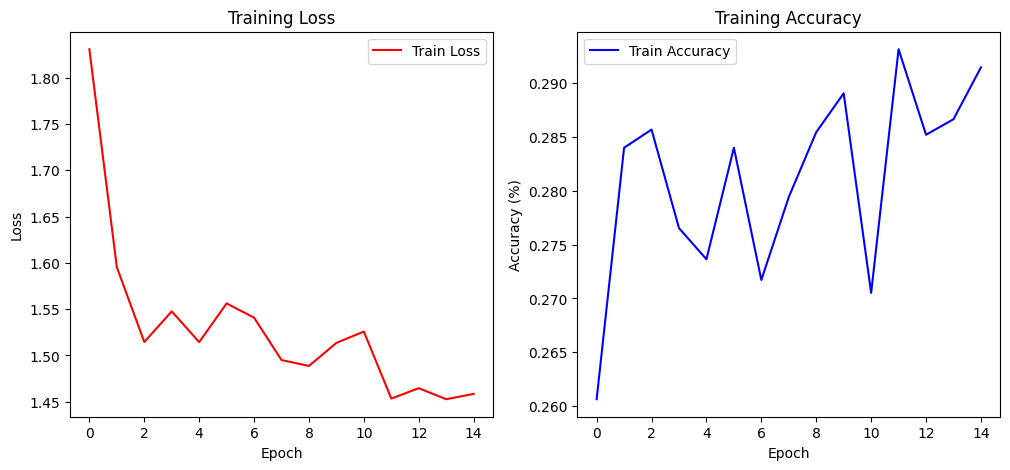

최종 학습 정확도: 29.15%


In [14]:
# [Cell 6] 개선된 학습 루프 (정확도 계산 및 그래프 시각화 포함)
import matplotlib.pyplot as plt

# 1. 데이터 로드
base_dir = '/content/drive/MyDrive/POC_Dataset'
train_dir = os.path.join(base_dir, 'Training')

print("Loading Training Data...")
# 메모리 절약을 위해 img_size는 64 유지
X_train_np, y_train_np = load_dataset(train_dir, img_size=64)
print(f"Train Data Shape: {X_train_np.shape}")

# 2. 모델 및 학습 설정
model = ResNet50(num_classes=4)
criterion = CrossEntropyLoss()
optimizer = Adam(lr=0.001)

BATCH_SIZE = 16
EPOCHS = 15 # 그래프 변화를 보기 위해 에폭을 조금 늘림

# 기록용 리스트
loss_history = []
acc_history = []

# 3. Training Loop
print("Start Training...")
num_train = X_train_np.shape[0]
num_batches = int(np.ceil(num_train / BATCH_SIZE))

for epoch in range(EPOCHS):
    epoch_loss = 0
    correct_count = 0
    total_count = 0
    start_time = time.time()

    # Shuffle
    perm = np.random.permutation(num_train)
    X_train_np = X_train_np[perm]
    y_train_np = y_train_np[perm]

    for i in range(num_batches):
        start = i * BATCH_SIZE
        end = min(start + BATCH_SIZE, num_train)

        batch_x = cp.array(X_train_np[start:end])
        batch_y = cp.array(y_train_np[start:end])

        # Forward
        logits = model.forward(batch_x)
        loss = criterion.forward(logits, batch_y)

        # Backward
        dout = criterion.backward()
        model.backward(dout)
        optimizer.step(model.get_all_params())

        # 정확도 및 Loss 계산
        epoch_loss += loss.item()

        # Accuracy Calculation (GPU 상에서 연산)
        preds = cp.argmax(logits, axis=1)
        targets = cp.argmax(batch_y, axis=1)
        correct_count += cp.sum(preds == targets).item()
        total_count += batch_y.shape[0]

        # 메모리 정리
        cp.get_default_memory_pool().free_all_blocks()

    # 에폭별 평균 계산
    avg_loss = epoch_loss / num_batches
    avg_acc = correct_count / total_count

    loss_history.append(avg_loss)
    acc_history.append(avg_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f} | Acc: {avg_acc*100:.2f}% | Time: {time.time()-start_time:.2f}s")

print("Training Finished.")

# 4. 결과 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Train Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc_history, label='Train Accuracy', color='blue')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

print(f"최종 학습 정확도: {acc_history[-1]*100:.2f}%")

In [15]:
# [Cell 7] 모델 테스트 (Test Dataset 평가)

def set_model_mode(model, mode='test'):
    """
    모델 내부의 모든 BatchNorm 레이어의 mode를 변경합니다.
    mode: 'train' or 'test'
    """
    # model.get_all_params()는 모든 레이어(Conv, BN, FC) 리스트를 반환함
    layers = model.get_all_params()
    for layer in layers:
        if isinstance(layer, BatchNorm):
            layer.mode = mode

def evaluate(model, X_test, y_test, batch_size=16):
    num_test = X_test.shape[0]
    num_batches = int(np.ceil(num_test / batch_size))

    correct_count = 0
    total_count = 0

    # 모델을 테스트 모드로 전환 (BatchNorm 통계량 고정)
    set_model_mode(model, 'test')

    print(f"Evaluating on {num_test} test images...")

    for i in range(num_batches):
        start = i * batch_size
        end = min(start + batch_size, num_test)

        batch_x = cp.array(X_test[start:end])
        batch_y = cp.array(y_test[start:end])

        # Forward Only (No Backward)
        logits = model.forward(batch_x)

        preds = cp.argmax(logits, axis=1)
        targets = cp.argmax(batch_y, axis=1)

        correct_count += cp.sum(preds == targets).item()
        total_count += batch_y.shape[0]

        # 메모리 정리
        cp.get_default_memory_pool().free_all_blocks()

    acc = correct_count / total_count
    return acc

# 1. 테스트 데이터 로드
test_dir = os.path.join(base_dir, 'Testing')
print("Loading Test Data...")
X_test_np, y_test_np = load_dataset(test_dir, img_size=64)

if len(X_test_np) == 0:
    print("Test 데이터가 없습니다. 경로를 확인해주세요.")
else:
    # 2. 평가 수행
    test_acc = evaluate(model, X_test_np, y_test_np, batch_size=BATCH_SIZE)

    print("="*30)
    print(f"최종 테스트 정확도 (Test Accuracy): {test_acc * 100:.2f}%")
    print("="*30)

Loading Test Data...
Loading Chorionic_villi...
Loading Decidual_tissue...
Loading Hemorrhage...
Loading Trophoblastic_tissue...
Evaluating on 1511 test images...
최종 테스트 정확도 (Test Accuracy): 26.74%


In [16]:
# [Cell 8] 데이터 증강 및 Early Stopping, LR Scheduler 구현

class DataAugmentor:
    def __init__(self):
        pass

    def augment(self, images):
        """
        images: (N, C, H, W) 형태의 CuPy 또는 NumPy 배열
        """
        # CPU(Numpy)로 변환해서 처리 후 다시 GPU로 올리는 것이 구현이 쉬움
        if isinstance(images, cp.ndarray):
            images = cp.asnumpy(images)

        N, C, H, W = images.shape
        augmented = images.copy()

        for i in range(N):
            img = augmented[i].transpose(1, 2, 0) # CHW -> HWC

            # 1. Random Horizontal Flip
            if np.random.rand() > 0.5:
                img = cv2.flip(img, 1)

            # 2. Random Rotation (-15 ~ 15 degree)
            if np.random.rand() > 0.5:
                angle = np.random.uniform(-15, 15)
                M = cv2.getRotationMatrix2D((W/2, H/2), angle, 1)
                img = cv2.warpAffine(img, M, (W, H), borderMode=cv2.BORDER_REFLECT)

            # 3. Brightness/Contrast Jitter
            if np.random.rand() > 0.5:
                alpha = np.random.uniform(0.8, 1.2) # Contrast
                beta = np.random.uniform(-0.1, 0.1) # Brightness
                img = img * alpha + beta
                img = np.clip(img, 0, 1)

            augmented[i] = img.transpose(2, 0, 1) # HWC -> CHW

        return cp.array(augmented)

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

class LRScheduler:
    def __init__(self, optimizer, patience=3, factor=0.5, min_lr=1e-6):
        self.optimizer = optimizer
        self.patience = patience
        self.factor = factor
        self.min_lr = min_lr
        self.counter = 0
        self.best_loss = None

    def step(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.counter >= self.patience:
                old_lr = self.optimizer.lr
                new_lr = max(old_lr * self.factor, self.min_lr)
                self.optimizer.lr = new_lr
                print(f" [Scheduler] Learning Rate decayed: {old_lr} -> {new_lr}")
                self.counter = 0
        else:
            self.best_loss = val_loss
            self.counter = 0

Loading Data & Splitting Validation Set...
Loading Chorionic_villi...
Loading Decidual_tissue...
Loading Hemorrhage...
Loading Trophoblastic_tissue...
Train Set: (3324, 3, 64, 64), Val Set: (831, 3, 64, 64)
Start Advanced Training...
Epoch 1/30 | T_Loss: 1.7156 T_Acc: 27.26% | V_Loss: 2.4137 V_Acc: 25.15% | 91.5s
Epoch 2/30 | T_Loss: 1.6099 T_Acc: 27.35% | V_Loss: 2.3633 V_Acc: 23.23% | 91.7s
Epoch 3/30 | T_Loss: 1.5392 T_Acc: 27.65% | V_Loss: 1.7229 V_Acc: 32.85% | 91.7s
Epoch 4/30 | T_Loss: 1.5068 T_Acc: 29.63% | V_Loss: 1.7194 V_Acc: 17.33% | 91.5s
Epoch 5/30 | T_Loss: 1.4985 T_Acc: 27.62% | V_Loss: 1.3906 V_Acc: 31.53% | 92.4s
Epoch 6/30 | T_Loss: 1.4957 T_Acc: 28.61% | V_Loss: 1.7937 V_Acc: 26.84% | 92.7s
Epoch 7/30 | T_Loss: 1.4934 T_Acc: 28.85% | V_Loss: 1.4313 V_Acc: 32.01% | 92.4s
Epoch 8/30 | T_Loss: 1.4634 T_Acc: 27.83% | V_Loss: 1.7038 V_Acc: 28.64% | 92.5s
 [Scheduler] Learning Rate decayed: 0.0005 -> 0.00025
Epoch 9/30 | T_Loss: 1.4189 T_Acc: 29.21% | V_Loss: 1.3964 V_Acc

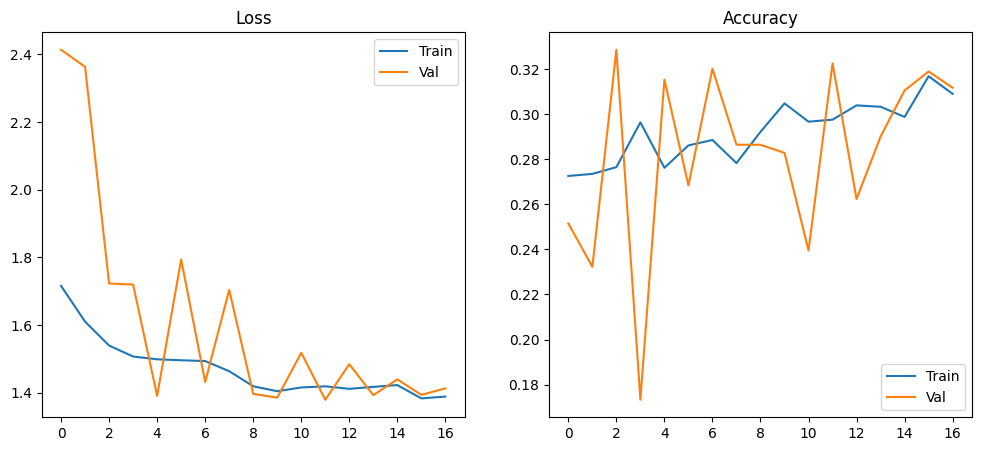

Evaluating on Testing Folder...
Evaluating on 1511 test images...
Final Test Accuracy: 27.20%


In [17]:
# [Cell 9] Validation 분리 + Augmentation + Early Stopping 적용 학습

# 1. 데이터 로드 및 검증 세트 분리
print("Loading Data & Splitting Validation Set...")
full_X, full_y = load_dataset(os.path.join(base_dir, 'Training'), img_size=64)

# 8:2 비율로 분리
num_full = full_X.shape[0]
split_idx = int(num_full * 0.8)

X_train, y_train = full_X[:split_idx], full_y[:split_idx]
X_val, y_val = full_X[split_idx:], full_y[split_idx:]

print(f"Train Set: {X_train.shape}, Val Set: {X_val.shape}")

# 2. 모델 재설정
model = ResNet50(num_classes=4)
criterion = CrossEntropyLoss()
# 학습률을 기존 0.001보다 약간 낮춰서 안정성 확보
optimizer = Adam(lr=0.0005)

augmentor = DataAugmentor()
early_stopper = EarlyStopping(patience=5, min_delta=0.001)
lr_scheduler = LRScheduler(optimizer, patience=3, factor=0.5)

BATCH_SIZE = 16
EPOCHS = 30 # Early Stopping이 있으므로 넉넉하게 설정

loss_history = {'train': [], 'val': []}
acc_history = {'train': [], 'val': []}

print("Start Advanced Training...")

for epoch in range(EPOCHS):
    start_time = time.time()

    # --- Training Phase ---
    set_model_mode(model, 'train') # Train 모드 (BatchNorm update)

    # Shuffle
    perm = np.random.permutation(len(X_train))
    X_train = X_train[perm]
    y_train = y_train[perm]

    train_loss = 0
    train_correct = 0
    num_batches = int(np.ceil(len(X_train) / BATCH_SIZE))

    for i in range(num_batches):
        start = i * BATCH_SIZE
        end = min(start + BATCH_SIZE, len(X_train))

        # CPU Numpy -> GPU Cupy
        batch_x_cpu = X_train[start:end]
        batch_y = cp.array(y_train[start:end])

        # ★ 데이터 증강 적용 (GPU로 올리기 전 혹은 올리면서 수행)
        batch_x = augmentor.augment(batch_x_cpu)

        # Forward
        logits = model.forward(batch_x)
        loss = criterion.forward(logits, batch_y)

        # Backward
        dout = criterion.backward()
        model.backward(dout)
        optimizer.step(model.get_all_params())

        train_loss += loss.item()
        preds = cp.argmax(logits, axis=1)
        targets = cp.argmax(batch_y, axis=1)
        train_correct += cp.sum(preds == targets).item()

        # 메모리 해제
        cp.get_default_memory_pool().free_all_blocks()

    avg_train_loss = train_loss / num_batches
    avg_train_acc = train_correct / len(X_train)

    # --- Validation Phase ---
    set_model_mode(model, 'test') # Test 모드 (BatchNorm fix)
    val_loss = 0
    val_correct = 0
    num_val_batches = int(np.ceil(len(X_val) / BATCH_SIZE))

    for i in range(num_val_batches):
        start = i * BATCH_SIZE
        end = min(start + BATCH_SIZE, len(X_val))

        # Validation은 증강 없이 원본 사용
        batch_x = cp.array(X_val[start:end])
        batch_y = cp.array(y_val[start:end])

        logits = model.forward(batch_x)
        loss = criterion.forward(logits, batch_y)

        val_loss += loss.item()
        preds = cp.argmax(logits, axis=1)
        targets = cp.argmax(batch_y, axis=1)
        val_correct += cp.sum(preds == targets).item()

    avg_val_loss = val_loss / num_val_batches
    avg_val_acc = val_correct / len(X_val)

    # --- Logging & Scheduling ---
    loss_history['train'].append(avg_train_loss)
    loss_history['val'].append(avg_val_loss)
    acc_history['train'].append(avg_train_acc)
    acc_history['val'].append(avg_val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | T_Loss: {avg_train_loss:.4f} T_Acc: {avg_train_acc*100:.2f}% | V_Loss: {avg_val_loss:.4f} V_Acc: {avg_val_acc*100:.2f}% | {time.time()-start_time:.1f}s")

    # Learning Rate Decay Check
    lr_scheduler.step(avg_val_loss)

    # Early Stopping Check
    early_stopper(avg_val_loss)
    if early_stopper.early_stop:
        print("Early stopping triggered.")
        break

print("Training Finished.")

# 결과 그래프
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history['train'], label='Train')
plt.plot(loss_history['val'], label='Val')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(acc_history['train'], label='Train')
plt.plot(acc_history['val'], label='Val')
plt.title('Accuracy')
plt.legend()
plt.show()

# 최종 테스트 (Testing 폴더)
print("Evaluating on Testing Folder...")
test_acc = evaluate(model, X_test_np, y_test_np, batch_size=BATCH_SIZE)
print(f"Final Test Accuracy: {test_acc*100:.2f}%")